# Import Required Libraries

In [1]:
WANDB = True
EXP_NAME = "val4-22_effnetb0_mixup"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# !apt-get install -y libgl1-mesa-dev


In [3]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [4]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 320,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 1e-3,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-7,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "save_dir": "../proc/val3",
    "use_tta": False,
    "mixup_alpha": 0.4,  # 既存のMixupのパラメータ
    "mixup_epochs": 40,  # Mixupを適用するエポック数を追加
    "dropout_rate": 0.2,
}

# Set Seed for Reproducibility

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [10]:
df_patient = df.groupby("patient_id")[["isic_id"]].agg(
    count_per_patient=("isic_id", "count"), 
).sort_values(by="count_per_patient").reset_index()
df_patient.head(2)

,patient_id,count_per_patient
0,IP_5792391,1
1,IP_1487179,1


In [11]:
df = df.merge(df_patient, on="patient_id", how="left")
df.shape[0], df.target.sum()

(401059, 393)

In [12]:
df.shape[0], df.target.sum()

(401059, 393)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [13]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


In [14]:
df["target_original"] = df["target"]
df.loc[(df["iddx_full"]!="Benign")&(df["target"]!=1), "target"] = 1
print(df.shape[0], df.target.sum())

401059 1068


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [15]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [16]:
# Mixupを行う関数を追加
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Batch size should be larger than 1"

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [17]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [18]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [19]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, dropout_rate=CONFIG['dropout_rate']):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        dropped_features = self.dropout(pooled_features)
        output = self.sigmoid(self.linear(dropped_features))
        return output

# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         super(ISICModel, self).__init__()
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
#         self.pooling = GeM()
#         self.linear = nn.Linear(in_features, num_classes)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, images):
#         features = self.model(images)
#         pooled_features = self.pooling(features).flatten(1)
#         output = self.sigmoid(self.linear(pooled_features))
#         return output

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [20]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)
#     return nn.CrossEntropyLoss()(outputs, targets) 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [21]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            mixed_images, targets_a, targets_b, lam = mixup(images, targets, alpha=CONFIG['mixup_alpha'])
            outputs = model(mixed_images).squeeze()
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [23]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = f"training_fold{fold}"
    # if not os.path.exists(save_dir):
    #     os.mkdir(save_dir)
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc:.5f} ---> {val_epoch_auroc:.5f})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            # 過去のベストモデルを削除
#             if 'PATH' in locals():
#                 os.remove(PATH)
            PATH = "training_fold{}/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(fold, val_epoch_auroc, val_epoch_loss, epoch)

        else:
            print(f"Validation pAUC80 not Improved ({val_epoch_auroc:.5f})")

        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # torch.save(best_model_wts, PATH)
    # Save a model file from the current directory
    # print(f"Best Model Saved{sr_}")
    
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model, history

In [25]:
def fetch_scheduler(optimizer, T_max):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [26]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# CV

In [27]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images", name=EXP_NAME, config=wandb_config)

In [28]:
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]
    df_val["target"] = df_val["target_original"]

    # trainのダウンサンプリング
    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_train[df_train["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    train_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    # optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
    #                         weight_decay=CONFIG['weight_decay'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(train_loader) * CONFIG["epochs"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, train_loader, valid_loader, history
    torch.cuda.empty_cache()

fold 0
●train
original> (306580, 59) 865 (835,)
filtered> (18165, 59) 865 (806,)
●val
original> (94479, 59) 73 (207,)
filtered> (1533, 59) 73 (180,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:02<00:00,  4.81it/s, Epoch=1, LR=0.000999, Valid_Loss=0.606]


Validation AUROC Improved (-inf ---> 0.09044)



100%|██████████| 12/12 [00:01<00:00,  6.27it/s, Epoch=2, LR=0.000996, Valid_Loss=0.403]


Validation AUROC Improved (0.09044 ---> 0.12326)



100%|██████████| 12/12 [00:01<00:00,  6.30it/s, Epoch=3, LR=0.000991, Valid_Loss=0.56] 


Validation AUROC Improved (0.12326 ---> 0.13009)



100%|██████████| 12/12 [00:01<00:00,  6.22it/s, Epoch=4, LR=0.000984, Valid_Loss=0.385]


Validation pAUC80 not Improved (0.12795)



100%|██████████| 12/12 [00:01<00:00,  6.29it/s, Epoch=5, LR=0.000976, Valid_Loss=0.559]


Validation AUROC Improved (0.13009 ---> 0.13655)



100%|██████████| 12/12 [00:01<00:00,  6.28it/s, Epoch=6, LR=0.000965, Valid_Loss=0.486]


Validation AUROC Improved (0.13655 ---> 0.14101)



100%|██████████| 12/12 [00:01<00:00,  6.21it/s, Epoch=7, LR=0.000952, Valid_Loss=0.365]


Validation pAUC80 not Improved (0.13028)



100%|██████████| 12/12 [00:01<00:00,  6.13it/s, Epoch=8, LR=0.000938, Valid_Loss=0.348]


Validation AUROC Improved (0.14101 ---> 0.14162)



100%|██████████| 12/12 [00:01<00:00,  6.10it/s, Epoch=9, LR=0.000922, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.13758)



100%|██████████| 12/12 [00:01<00:00,  6.05it/s, Epoch=10, LR=0.000905, Valid_Loss=0.255]


Validation AUROC Improved (0.14162 ---> 0.15692)



100%|██████████| 12/12 [00:01<00:00,  6.19it/s, Epoch=11, LR=0.000885, Valid_Loss=0.378]


Validation pAUC80 not Improved (0.14388)



100%|██████████| 12/12 [00:01<00:00,  6.17it/s, Epoch=12, LR=0.000864, Valid_Loss=0.386]


Validation pAUC80 not Improved (0.14697)



100%|██████████| 12/12 [00:02<00:00,  5.88it/s, Epoch=13, LR=0.000842, Valid_Loss=0.33] 


Validation pAUC80 not Improved (0.14633)



100%|██████████| 12/12 [00:01<00:00,  6.29it/s, Epoch=14, LR=0.000819, Valid_Loss=0.276]


Validation pAUC80 not Improved (0.14941)



100%|██████████| 12/12 [00:01<00:00,  6.37it/s, Epoch=15, LR=0.000794, Valid_Loss=0.417]


Validation pAUC80 not Improved (0.14785)



100%|██████████| 12/12 [00:01<00:00,  6.10it/s, Epoch=16, LR=0.000768, Valid_Loss=0.298]


Validation pAUC80 not Improved (0.15142)



100%|██████████| 12/12 [00:01<00:00,  6.03it/s, Epoch=17, LR=0.000741, Valid_Loss=0.278]


Validation pAUC80 not Improved (0.14385)



100%|██████████| 12/12 [00:01<00:00,  6.16it/s, Epoch=18, LR=0.000713, Valid_Loss=0.346]


Validation pAUC80 not Improved (0.14701)



100%|██████████| 12/12 [00:01<00:00,  6.17it/s, Epoch=19, LR=0.000684, Valid_Loss=0.347]


Validation pAUC80 not Improved (0.14503)



100%|██████████| 12/12 [00:01<00:00,  6.16it/s, Epoch=20, LR=0.000655, Valid_Loss=0.33] 


Validation pAUC80 not Improved (0.15362)



100%|██████████| 12/12 [00:01<00:00,  6.21it/s, Epoch=21, LR=0.000624, Valid_Loss=0.387]


Validation pAUC80 not Improved (0.15351)



100%|██████████| 12/12 [00:01<00:00,  6.34it/s, Epoch=22, LR=0.000594, Valid_Loss=0.271]


Validation pAUC80 not Improved (0.15053)



100%|██████████| 12/12 [00:02<00:00,  5.95it/s, Epoch=23, LR=0.000563, Valid_Loss=0.337]


Validation pAUC80 not Improved (0.15440)



100%|██████████| 12/12 [00:01<00:00,  6.17it/s, Epoch=24, LR=0.000531, Valid_Loss=0.293]


Validation AUROC Improved (0.15692 ---> 0.15733)



100%|██████████| 12/12 [00:01<00:00,  6.16it/s, Epoch=25, LR=0.0005, Valid_Loss=0.273]


Validation AUROC Improved (0.15733 ---> 0.15837)



100%|██████████| 12/12 [00:01<00:00,  6.09it/s, Epoch=26, LR=0.000469, Valid_Loss=0.331]


Validation AUROC Improved (0.15837 ---> 0.15921)



100%|██████████| 12/12 [00:01<00:00,  6.18it/s, Epoch=27, LR=0.000437, Valid_Loss=0.351]


Validation pAUC80 not Improved (0.14610)



100%|██████████| 12/12 [00:01<00:00,  6.15it/s, Epoch=28, LR=0.000406, Valid_Loss=0.367]


Validation pAUC80 not Improved (0.15380)



100%|██████████| 12/12 [00:01<00:00,  6.45it/s, Epoch=29, LR=0.000376, Valid_Loss=0.279]


Validation AUROC Improved (0.15921 ---> 0.16119)



100%|██████████| 12/12 [00:01<00:00,  6.09it/s, Epoch=30, LR=0.000346, Valid_Loss=0.232]


Validation AUROC Improved (0.16119 ---> 0.16552)



100%|██████████| 12/12 [00:01<00:00,  6.13it/s, Epoch=31, LR=0.000316, Valid_Loss=0.254]


Validation pAUC80 not Improved (0.15445)



100%|██████████| 12/12 [00:01<00:00,  6.23it/s, Epoch=32, LR=0.000287, Valid_Loss=0.25]


Validation pAUC80 not Improved (0.15373)



100%|██████████| 12/12 [00:01<00:00,  6.24it/s, Epoch=33, LR=0.000259, Valid_Loss=0.29] 


Validation pAUC80 not Improved (0.14832)



100%|██████████| 12/12 [00:01<00:00,  6.09it/s, Epoch=34, LR=0.000232, Valid_Loss=0.284]


Validation pAUC80 not Improved (0.15262)



100%|██████████| 12/12 [00:01<00:00,  6.27it/s, Epoch=35, LR=0.000206, Valid_Loss=0.285]


Validation pAUC80 not Improved (0.15128)



100%|██████████| 12/12 [00:01<00:00,  6.15it/s, Epoch=36, LR=0.000181, Valid_Loss=0.3]  


Validation pAUC80 not Improved (0.14729)



100%|██████████| 12/12 [00:01<00:00,  6.34it/s, Epoch=37, LR=0.000158, Valid_Loss=0.28] 


Validation pAUC80 not Improved (0.15088)



100%|██████████| 12/12 [00:01<00:00,  6.15it/s, Epoch=38, LR=0.000136, Valid_Loss=0.242]


Validation pAUC80 not Improved (0.15189)



100%|██████████| 12/12 [00:01<00:00,  6.08it/s, Epoch=39, LR=0.000115, Valid_Loss=0.262]


Validation pAUC80 not Improved (0.15087)



100%|██████████| 12/12 [00:01<00:00,  6.37it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.303]


Validation pAUC80 not Improved (0.15352)



100%|██████████| 12/12 [00:01<00:00,  6.10it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.272]


Validation pAUC80 not Improved (0.15798)



100%|██████████| 12/12 [00:01<00:00,  6.21it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.276]


Validation pAUC80 not Improved (0.15880)



100%|██████████| 12/12 [00:01<00:00,  6.15it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.302]


Validation pAUC80 not Improved (0.15690)



100%|██████████| 12/12 [00:02<00:00,  5.98it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.275]


Validation pAUC80 not Improved (0.15752)



100%|██████████| 12/12 [00:01<00:00,  6.31it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.27] 


Validation pAUC80 not Improved (0.15834)



100%|██████████| 12/12 [00:01<00:00,  6.19it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.315]


Validation pAUC80 not Improved (0.15625)



100%|██████████| 12/12 [00:01<00:00,  6.15it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.273]


Validation pAUC80 not Improved (0.15681)



100%|██████████| 12/12 [00:01<00:00,  6.22it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.295]


Validation pAUC80 not Improved (0.15658)



100%|██████████| 12/12 [00:01<00:00,  6.07it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.284]


Validation pAUC80 not Improved (0.15658)



100%|██████████| 12/12 [00:01<00:00,  6.05it/s, Epoch=50, LR=1e-7, Valid_Loss=0.3]  


Validation pAUC80 not Improved (0.15568)

Training complete in 0h 6m 20s
Best AUROC: 0.1655
fold 1
●train
original> (315046, 59) 836 (833,)
filtered> (17556, 59) 836 (806,)
●val
original> (86013, 59) 96 (209,)
filtered> (2016, 59) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:02<00:00,  6.23it/s, Epoch=1, LR=0.000999, Valid_Loss=0.49] 


Validation AUROC Improved (-inf ---> 0.09199)



100%|██████████| 16/16 [00:02<00:00,  6.40it/s, Epoch=2, LR=0.000996, Valid_Loss=0.929]


Validation AUROC Improved (0.09199 ---> 0.13860)



100%|██████████| 16/16 [00:02<00:00,  6.46it/s, Epoch=3, LR=0.000991, Valid_Loss=0.48] 


Validation pAUC80 not Improved (0.12632)



100%|██████████| 16/16 [00:02<00:00,  6.40it/s, Epoch=4, LR=0.000984, Valid_Loss=0.292]


Validation AUROC Improved (0.13860 ---> 0.13952)



100%|██████████| 16/16 [00:02<00:00,  6.42it/s, Epoch=5, LR=0.000976, Valid_Loss=0.576]


Validation pAUC80 not Improved (0.13565)



100%|██████████| 16/16 [00:02<00:00,  6.44it/s, Epoch=6, LR=0.000965, Valid_Loss=0.328]


Validation pAUC80 not Improved (0.13203)



100%|██████████| 16/16 [00:02<00:00,  5.98it/s, Epoch=7, LR=0.000952, Valid_Loss=0.471]


Validation AUROC Improved (0.13952 ---> 0.14129)



100%|██████████| 16/16 [00:02<00:00,  6.36it/s, Epoch=8, LR=0.000938, Valid_Loss=0.45] 


Validation pAUC80 not Improved (0.13448)



100%|██████████| 16/16 [00:02<00:00,  6.36it/s, Epoch=9, LR=0.000922, Valid_Loss=0.256]


Validation pAUC80 not Improved (0.13992)



100%|██████████| 16/16 [00:02<00:00,  6.32it/s, Epoch=10, LR=0.000905, Valid_Loss=0.329]


Validation AUROC Improved (0.14129 ---> 0.14718)



100%|██████████| 16/16 [00:02<00:00,  6.49it/s, Epoch=11, LR=0.000885, Valid_Loss=0.389]


Validation pAUC80 not Improved (0.13496)



100%|██████████| 16/16 [00:02<00:00,  6.24it/s, Epoch=12, LR=0.000864, Valid_Loss=0.353]


Validation AUROC Improved (0.14718 ---> 0.15219)



100%|██████████| 16/16 [00:02<00:00,  6.23it/s, Epoch=13, LR=0.000842, Valid_Loss=0.234]


Validation pAUC80 not Improved (0.13565)



100%|██████████| 16/16 [00:02<00:00,  6.42it/s, Epoch=14, LR=0.000819, Valid_Loss=0.341]


Validation pAUC80 not Improved (0.13476)



100%|██████████| 16/16 [00:02<00:00,  6.56it/s, Epoch=15, LR=0.000794, Valid_Loss=0.329]


Validation pAUC80 not Improved (0.14957)



100%|██████████| 16/16 [00:02<00:00,  6.45it/s, Epoch=16, LR=0.000768, Valid_Loss=0.429]


Validation pAUC80 not Improved (0.14520)



100%|██████████| 16/16 [00:02<00:00,  6.49it/s, Epoch=17, LR=0.000741, Valid_Loss=0.352]


Validation pAUC80 not Improved (0.14246)



100%|██████████| 16/16 [00:02<00:00,  6.39it/s, Epoch=18, LR=0.000713, Valid_Loss=0.285]


Validation pAUC80 not Improved (0.14755)



100%|██████████| 16/16 [00:02<00:00,  6.12it/s, Epoch=19, LR=0.000684, Valid_Loss=0.452]


Validation pAUC80 not Improved (0.14766)



100%|██████████| 16/16 [00:02<00:00,  6.29it/s, Epoch=20, LR=0.000655, Valid_Loss=0.321]


Validation pAUC80 not Improved (0.13407)



100%|██████████| 16/16 [00:02<00:00,  6.18it/s, Epoch=21, LR=0.000624, Valid_Loss=0.317]


Validation pAUC80 not Improved (0.13640)



100%|██████████| 16/16 [00:02<00:00,  6.52it/s, Epoch=22, LR=0.000594, Valid_Loss=0.454]


Validation pAUC80 not Improved (0.14825)



100%|██████████| 16/16 [00:02<00:00,  6.39it/s, Epoch=23, LR=0.000563, Valid_Loss=0.381]


Validation pAUC80 not Improved (0.14290)



100%|██████████| 16/16 [00:02<00:00,  6.17it/s, Epoch=24, LR=0.000531, Valid_Loss=0.297]


Validation pAUC80 not Improved (0.14119)



100%|██████████| 16/16 [00:02<00:00,  6.40it/s, Epoch=25, LR=0.0005, Valid_Loss=0.323]


Validation pAUC80 not Improved (0.13588)



100%|██████████| 16/16 [00:02<00:00,  6.34it/s, Epoch=26, LR=0.000469, Valid_Loss=0.306]


Validation pAUC80 not Improved (0.14474)



100%|██████████| 16/16 [00:02<00:00,  6.54it/s, Epoch=27, LR=0.000437, Valid_Loss=0.393]


Validation pAUC80 not Improved (0.14643)



100%|██████████| 16/16 [00:02<00:00,  6.52it/s, Epoch=28, LR=0.000406, Valid_Loss=0.275]


Validation pAUC80 not Improved (0.14881)



100%|██████████| 16/16 [00:02<00:00,  6.56it/s, Epoch=29, LR=0.000376, Valid_Loss=0.37] 


Validation pAUC80 not Improved (0.14682)



100%|██████████| 16/16 [00:02<00:00,  6.18it/s, Epoch=30, LR=0.000346, Valid_Loss=0.384]


Validation pAUC80 not Improved (0.14445)



100%|██████████| 16/16 [00:02<00:00,  6.60it/s, Epoch=31, LR=0.000316, Valid_Loss=0.341]


Validation pAUC80 not Improved (0.14155)



100%|██████████| 16/16 [00:02<00:00,  6.73it/s, Epoch=32, LR=0.000287, Valid_Loss=0.327]


Validation pAUC80 not Improved (0.13972)



100%|██████████| 16/16 [00:02<00:00,  6.51it/s, Epoch=33, LR=0.000259, Valid_Loss=0.376]


Validation pAUC80 not Improved (0.14824)



100%|██████████| 16/16 [00:02<00:00,  6.05it/s, Epoch=34, LR=0.000232, Valid_Loss=0.269]


Validation pAUC80 not Improved (0.14586)



100%|██████████| 16/16 [00:02<00:00,  6.39it/s, Epoch=35, LR=0.000206, Valid_Loss=0.279]


Validation pAUC80 not Improved (0.14109)



100%|██████████| 16/16 [00:02<00:00,  6.57it/s, Epoch=36, LR=0.000181, Valid_Loss=0.27] 


Validation pAUC80 not Improved (0.13640)



100%|██████████| 16/16 [00:02<00:00,  6.39it/s, Epoch=37, LR=0.000158, Valid_Loss=0.324]


Validation pAUC80 not Improved (0.14401)



100%|██████████| 16/16 [00:02<00:00,  6.11it/s, Epoch=38, LR=0.000136, Valid_Loss=0.31] 


Validation pAUC80 not Improved (0.14420)



100%|██████████| 16/16 [00:02<00:00,  6.49it/s, Epoch=39, LR=0.000115, Valid_Loss=0.316]


Validation pAUC80 not Improved (0.14230)



100%|██████████| 16/16 [00:02<00:00,  6.43it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.305]


Validation pAUC80 not Improved (0.14264)



100%|██████████| 16/16 [00:02<00:00,  6.41it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.315]


Validation pAUC80 not Improved (0.14838)



100%|██████████| 16/16 [00:02<00:00,  6.17it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.278]


Validation pAUC80 not Improved (0.14872)



100%|██████████| 16/16 [00:02<00:00,  6.50it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.3]  


Validation pAUC80 not Improved (0.15016)



100%|██████████| 16/16 [00:02<00:00,  6.37it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.311]


Validation pAUC80 not Improved (0.14679)



100%|██████████| 16/16 [00:02<00:00,  6.54it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.287]


Validation pAUC80 not Improved (0.14757)



100%|██████████| 16/16 [00:02<00:00,  6.41it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.314]


Validation pAUC80 not Improved (0.14614)



100%|██████████| 16/16 [00:02<00:00,  6.53it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.293]


Validation pAUC80 not Improved (0.14570)



100%|██████████| 16/16 [00:02<00:00,  6.55it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.319]


Validation pAUC80 not Improved (0.14551)



100%|██████████| 16/16 [00:02<00:00,  6.58it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.33] 


Validation pAUC80 not Improved (0.14400)



100%|██████████| 16/16 [00:02<00:00,  6.21it/s, Epoch=50, LR=1e-7, Valid_Loss=0.336]


Validation pAUC80 not Improved (0.14311)

Training complete in 0h 6m 40s
Best AUROC: 0.1522
fold 2
●train
original> (326063, 59) 886 (833,)
filtered> (18606, 59) 886 (814,)
●val
original> (74996, 59) 58 (209,)
filtered> (1218, 59) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:01<00:00,  5.92it/s, Epoch=1, LR=0.000999, Valid_Loss=0.614]


Validation AUROC Improved (-inf ---> 0.08583)



100%|██████████| 10/10 [00:01<00:00,  5.68it/s, Epoch=2, LR=0.000996, Valid_Loss=0.602]


Validation AUROC Improved (0.08583 ---> 0.13810)



100%|██████████| 10/10 [00:01<00:00,  6.04it/s, Epoch=3, LR=0.000991, Valid_Loss=0.568]


Validation pAUC80 not Improved (0.12979)



100%|██████████| 10/10 [00:01<00:00,  6.12it/s, Epoch=4, LR=0.000984, Valid_Loss=0.591]


Validation pAUC80 not Improved (0.12967)



100%|██████████| 10/10 [00:01<00:00,  6.20it/s, Epoch=5, LR=0.000976, Valid_Loss=0.404]


Validation pAUC80 not Improved (0.13076)



100%|██████████| 10/10 [00:01<00:00,  6.16it/s, Epoch=6, LR=0.000965, Valid_Loss=0.379]


Validation AUROC Improved (0.13810 ---> 0.14013)



100%|██████████| 10/10 [00:01<00:00,  6.09it/s, Epoch=7, LR=0.000952, Valid_Loss=0.483]


Validation pAUC80 not Improved (0.12949)



100%|██████████| 10/10 [00:01<00:00,  6.14it/s, Epoch=8, LR=0.000938, Valid_Loss=0.497]


Validation pAUC80 not Improved (0.13196)



100%|██████████| 10/10 [00:01<00:00,  6.02it/s, Epoch=9, LR=0.000922, Valid_Loss=0.424]


Validation AUROC Improved (0.14013 ---> 0.14333)



100%|██████████| 10/10 [00:01<00:00,  6.14it/s, Epoch=10, LR=0.000905, Valid_Loss=0.514]


Validation pAUC80 not Improved (0.13008)



100%|██████████| 10/10 [00:01<00:00,  6.18it/s, Epoch=11, LR=0.000885, Valid_Loss=0.512]


Validation AUROC Improved (0.14333 ---> 0.14734)



100%|██████████| 10/10 [00:01<00:00,  5.96it/s, Epoch=12, LR=0.000864, Valid_Loss=0.426]


Validation AUROC Improved (0.14734 ---> 0.15299)



100%|██████████| 10/10 [00:01<00:00,  6.32it/s, Epoch=13, LR=0.000842, Valid_Loss=0.437]


Validation pAUC80 not Improved (0.14134)



100%|██████████| 10/10 [00:01<00:00,  6.23it/s, Epoch=14, LR=0.000819, Valid_Loss=0.418]


Validation pAUC80 not Improved (0.14541)



100%|██████████| 10/10 [00:01<00:00,  5.97it/s, Epoch=15, LR=0.000794, Valid_Loss=0.467]


Validation pAUC80 not Improved (0.13563)



100%|██████████| 10/10 [00:01<00:00,  6.19it/s, Epoch=16, LR=0.000768, Valid_Loss=0.372]


Validation pAUC80 not Improved (0.14549)



100%|██████████| 10/10 [00:01<00:00,  6.03it/s, Epoch=17, LR=0.000741, Valid_Loss=0.449]


Validation pAUC80 not Improved (0.14837)



100%|██████████| 10/10 [00:01<00:00,  6.21it/s, Epoch=18, LR=0.000713, Valid_Loss=0.392]


Validation pAUC80 not Improved (0.14674)



100%|██████████| 10/10 [00:01<00:00,  6.22it/s, Epoch=19, LR=0.000684, Valid_Loss=0.482]


Validation AUROC Improved (0.15299 ---> 0.16229)



100%|██████████| 10/10 [00:01<00:00,  6.23it/s, Epoch=20, LR=0.000655, Valid_Loss=0.47]


Validation pAUC80 not Improved (0.15282)



100%|██████████| 10/10 [00:01<00:00,  6.25it/s, Epoch=21, LR=0.000624, Valid_Loss=0.484]


Validation pAUC80 not Improved (0.15890)



100%|██████████| 10/10 [00:01<00:00,  6.16it/s, Epoch=22, LR=0.000594, Valid_Loss=0.377]


Validation pAUC80 not Improved (0.15507)



100%|██████████| 10/10 [00:01<00:00,  6.15it/s, Epoch=23, LR=0.000563, Valid_Loss=0.368]


Validation pAUC80 not Improved (0.14991)



100%|██████████| 10/10 [00:01<00:00,  6.12it/s, Epoch=24, LR=0.000531, Valid_Loss=0.372]


Validation pAUC80 not Improved (0.14658)



100%|██████████| 10/10 [00:01<00:00,  6.15it/s, Epoch=25, LR=0.0005, Valid_Loss=0.422]


Validation pAUC80 not Improved (0.15411)



100%|██████████| 10/10 [00:01<00:00,  6.12it/s, Epoch=26, LR=0.000469, Valid_Loss=0.418]


Validation pAUC80 not Improved (0.15609)



100%|██████████| 10/10 [00:01<00:00,  5.84it/s, Epoch=27, LR=0.000437, Valid_Loss=0.506]


Validation pAUC80 not Improved (0.16020)



100%|██████████| 10/10 [00:01<00:00,  6.20it/s, Epoch=28, LR=0.000406, Valid_Loss=0.412]


Validation pAUC80 not Improved (0.15113)



100%|██████████| 10/10 [00:01<00:00,  6.14it/s, Epoch=29, LR=0.000376, Valid_Loss=0.403]


Validation pAUC80 not Improved (0.14981)



100%|██████████| 10/10 [00:01<00:00,  6.28it/s, Epoch=30, LR=0.000346, Valid_Loss=0.416]


Validation pAUC80 not Improved (0.14061)



100%|██████████| 10/10 [00:01<00:00,  6.12it/s, Epoch=31, LR=0.000316, Valid_Loss=0.445]


Validation pAUC80 not Improved (0.14869)



100%|██████████| 10/10 [00:01<00:00,  6.22it/s, Epoch=32, LR=0.000287, Valid_Loss=0.487]


Validation pAUC80 not Improved (0.16106)



100%|██████████| 10/10 [00:01<00:00,  6.16it/s, Epoch=33, LR=0.000259, Valid_Loss=0.473]


Validation pAUC80 not Improved (0.15812)



100%|██████████| 10/10 [00:01<00:00,  6.21it/s, Epoch=34, LR=0.000232, Valid_Loss=0.37]


Validation pAUC80 not Improved (0.15702)



100%|██████████| 10/10 [00:01<00:00,  6.19it/s, Epoch=35, LR=0.000206, Valid_Loss=0.414]


Validation pAUC80 not Improved (0.15645)



100%|██████████| 10/10 [00:01<00:00,  5.94it/s, Epoch=36, LR=0.000181, Valid_Loss=0.366]


Validation pAUC80 not Improved (0.15936)



100%|██████████| 10/10 [00:01<00:00,  6.17it/s, Epoch=37, LR=0.000158, Valid_Loss=0.421]


Validation pAUC80 not Improved (0.15530)



100%|██████████| 10/10 [00:01<00:00,  5.96it/s, Epoch=38, LR=0.000136, Valid_Loss=0.351]


Validation pAUC80 not Improved (0.15130)



100%|██████████| 10/10 [00:01<00:00,  6.09it/s, Epoch=39, LR=0.000115, Valid_Loss=0.388]


Validation pAUC80 not Improved (0.15133)



100%|██████████| 10/10 [00:01<00:00,  5.87it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.39]


Validation pAUC80 not Improved (0.15718)



100%|██████████| 10/10 [00:01<00:00,  6.04it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.369]


Validation pAUC80 not Improved (0.15397)



100%|██████████| 10/10 [00:01<00:00,  6.17it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.389]


Validation pAUC80 not Improved (0.15767)



100%|██████████| 10/10 [00:01<00:00,  6.30it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.376]


Validation pAUC80 not Improved (0.15540)



100%|██████████| 10/10 [00:01<00:00,  6.09it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.384]


Validation pAUC80 not Improved (0.15498)



100%|██████████| 10/10 [00:01<00:00,  6.23it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.388]


Validation pAUC80 not Improved (0.15456)



100%|██████████| 10/10 [00:01<00:00,  6.15it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.41]


Validation pAUC80 not Improved (0.15482)



100%|██████████| 10/10 [00:01<00:00,  5.91it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.406]


Validation pAUC80 not Improved (0.15548)



100%|██████████| 10/10 [00:01<00:00,  6.06it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.396]


Validation pAUC80 not Improved (0.15461)



100%|██████████| 10/10 [00:01<00:00,  6.07it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.438]


Validation pAUC80 not Improved (0.15418)



100%|██████████| 10/10 [00:01<00:00,  6.24it/s, Epoch=50, LR=1e-7, Valid_Loss=0.433]


Validation pAUC80 not Improved (0.15427)

Training complete in 0h 5m 59s
Best AUROC: 0.1623
fold 3
●train
original> (325562, 59) 852 (833,)
filtered> (17892, 59) 852 (809,)
●val
original> (75497, 59) 68 (209,)
filtered> (1428, 59) 68 (190,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:02<00:00,  5.79it/s, Epoch=1, LR=0.000999, Valid_Loss=0.71] 


Validation AUROC Improved (-inf ---> 0.09955)



100%|██████████| 12/12 [00:01<00:00,  6.28it/s, Epoch=2, LR=0.000996, Valid_Loss=0.61] 


Validation AUROC Improved (0.09955 ---> 0.13667)



100%|██████████| 12/12 [00:01<00:00,  6.42it/s, Epoch=3, LR=0.000991, Valid_Loss=0.669]


Validation pAUC80 not Improved (0.12323)



100%|██████████| 12/12 [00:01<00:00,  6.39it/s, Epoch=4, LR=0.000984, Valid_Loss=0.472]


Validation pAUC80 not Improved (0.12257)



100%|██████████| 12/12 [00:01<00:00,  6.01it/s, Epoch=5, LR=0.000976, Valid_Loss=0.413]


Validation pAUC80 not Improved (0.12336)



100%|██████████| 12/12 [00:01<00:00,  6.18it/s, Epoch=6, LR=0.000965, Valid_Loss=0.465]


Validation pAUC80 not Improved (0.13413)



100%|██████████| 12/12 [00:01<00:00,  6.16it/s, Epoch=7, LR=0.000952, Valid_Loss=0.518]


Validation AUROC Improved (0.13667 ---> 0.14348)



100%|██████████| 12/12 [00:01<00:00,  6.33it/s, Epoch=8, LR=0.000938, Valid_Loss=0.401]


Validation pAUC80 not Improved (0.14344)



100%|██████████| 12/12 [00:01<00:00,  6.37it/s, Epoch=9, LR=0.000922, Valid_Loss=0.313]


Validation pAUC80 not Improved (0.13793)



100%|██████████| 12/12 [00:01<00:00,  6.22it/s, Epoch=10, LR=0.000905, Valid_Loss=0.49] 


Validation AUROC Improved (0.14348 ---> 0.14606)



100%|██████████| 12/12 [00:01<00:00,  6.20it/s, Epoch=11, LR=0.000885, Valid_Loss=0.39] 


Validation pAUC80 not Improved (0.14438)



100%|██████████| 12/12 [00:01<00:00,  6.04it/s, Epoch=12, LR=0.000864, Valid_Loss=0.363]


Validation pAUC80 not Improved (0.13121)



100%|██████████| 12/12 [00:01<00:00,  6.38it/s, Epoch=13, LR=0.000842, Valid_Loss=0.407]


Validation pAUC80 not Improved (0.13652)



100%|██████████| 12/12 [00:01<00:00,  6.04it/s, Epoch=14, LR=0.000819, Valid_Loss=0.372]


Validation pAUC80 not Improved (0.13807)



100%|██████████| 12/12 [00:01<00:00,  6.13it/s, Epoch=15, LR=0.000794, Valid_Loss=0.417]


Validation pAUC80 not Improved (0.14289)



100%|██████████| 12/12 [00:01<00:00,  6.17it/s, Epoch=16, LR=0.000768, Valid_Loss=0.268]


Validation pAUC80 not Improved (0.13776)



100%|██████████| 12/12 [00:01<00:00,  6.39it/s, Epoch=17, LR=0.000741, Valid_Loss=0.537]


Validation pAUC80 not Improved (0.14272)



100%|██████████| 12/12 [00:01<00:00,  6.26it/s, Epoch=18, LR=0.000713, Valid_Loss=0.444]


Validation AUROC Improved (0.14606 ---> 0.15081)



100%|██████████| 12/12 [00:01<00:00,  6.21it/s, Epoch=19, LR=0.000684, Valid_Loss=0.438]


Validation AUROC Improved (0.15081 ---> 0.15223)



100%|██████████| 12/12 [00:01<00:00,  6.41it/s, Epoch=20, LR=0.000655, Valid_Loss=0.387]


Validation pAUC80 not Improved (0.12626)



100%|██████████| 12/12 [00:01<00:00,  6.54it/s, Epoch=21, LR=0.000624, Valid_Loss=0.565]


Validation pAUC80 not Improved (0.14044)



100%|██████████| 12/12 [00:02<00:00,  5.98it/s, Epoch=22, LR=0.000594, Valid_Loss=0.448]


Validation pAUC80 not Improved (0.14181)



100%|██████████| 12/12 [00:01<00:00,  6.27it/s, Epoch=23, LR=0.000563, Valid_Loss=0.344]


Validation pAUC80 not Improved (0.13650)



100%|██████████| 12/12 [00:01<00:00,  6.24it/s, Epoch=24, LR=0.000531, Valid_Loss=0.403]


Validation pAUC80 not Improved (0.12641)



100%|██████████| 12/12 [00:01<00:00,  6.35it/s, Epoch=25, LR=0.0005, Valid_Loss=0.399]


Validation pAUC80 not Improved (0.13468)



100%|██████████| 12/12 [00:01<00:00,  6.43it/s, Epoch=26, LR=0.000469, Valid_Loss=0.358]


Validation pAUC80 not Improved (0.13083)



100%|██████████| 12/12 [00:01<00:00,  6.45it/s, Epoch=27, LR=0.000437, Valid_Loss=0.314]


Validation pAUC80 not Improved (0.13358)



100%|██████████| 12/12 [00:01<00:00,  6.10it/s, Epoch=28, LR=0.000406, Valid_Loss=0.388]


Validation pAUC80 not Improved (0.13627)



100%|██████████| 12/12 [00:01<00:00,  6.27it/s, Epoch=29, LR=0.000376, Valid_Loss=0.293]


Validation pAUC80 not Improved (0.13349)



100%|██████████| 12/12 [00:01<00:00,  6.17it/s, Epoch=30, LR=0.000346, Valid_Loss=0.342]


Validation pAUC80 not Improved (0.13328)



100%|██████████| 12/12 [00:01<00:00,  6.40it/s, Epoch=31, LR=0.000316, Valid_Loss=0.331]


Validation pAUC80 not Improved (0.13749)



100%|██████████| 12/12 [00:01<00:00,  6.03it/s, Epoch=32, LR=0.000287, Valid_Loss=0.359]


Validation pAUC80 not Improved (0.14326)



100%|██████████| 12/12 [00:01<00:00,  6.24it/s, Epoch=33, LR=0.000259, Valid_Loss=0.34] 


Validation pAUC80 not Improved (0.13484)



100%|██████████| 12/12 [00:01<00:00,  6.54it/s, Epoch=34, LR=0.000232, Valid_Loss=0.345]


Validation pAUC80 not Improved (0.13571)



100%|██████████| 12/12 [00:01<00:00,  6.23it/s, Epoch=35, LR=0.000206, Valid_Loss=0.328]


Validation pAUC80 not Improved (0.14313)



100%|██████████| 12/12 [00:01<00:00,  6.50it/s, Epoch=36, LR=0.000181, Valid_Loss=0.338]


Validation pAUC80 not Improved (0.13430)



100%|██████████| 12/12 [00:01<00:00,  6.19it/s, Epoch=37, LR=0.000158, Valid_Loss=0.357]


Validation pAUC80 not Improved (0.13018)



100%|██████████| 12/12 [00:01<00:00,  6.53it/s, Epoch=38, LR=0.000136, Valid_Loss=0.323]


Validation pAUC80 not Improved (0.13428)



100%|██████████| 12/12 [00:01<00:00,  6.02it/s, Epoch=39, LR=0.000115, Valid_Loss=0.34] 


Validation pAUC80 not Improved (0.13851)



100%|██████████| 12/12 [00:01<00:00,  6.42it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.302]


Validation pAUC80 not Improved (0.13861)



100%|██████████| 12/12 [00:01<00:00,  6.45it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.327]


Validation pAUC80 not Improved (0.14384)



100%|██████████| 12/12 [00:01<00:00,  6.36it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.359]


Validation pAUC80 not Improved (0.14541)



100%|██████████| 12/12 [00:01<00:00,  6.13it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.336]


Validation pAUC80 not Improved (0.14179)



100%|██████████| 12/12 [00:01<00:00,  6.03it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.365]


Validation pAUC80 not Improved (0.14223)



100%|██████████| 12/12 [00:01<00:00,  6.44it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.347]


Validation pAUC80 not Improved (0.14371)



100%|██████████| 12/12 [00:01<00:00,  6.21it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.356]


Validation pAUC80 not Improved (0.14496)



100%|██████████| 12/12 [00:01<00:00,  6.36it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.349]


Validation pAUC80 not Improved (0.14450)



100%|██████████| 12/12 [00:01<00:00,  6.21it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.365]


Validation pAUC80 not Improved (0.14535)



100%|██████████| 12/12 [00:01<00:00,  6.36it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.357]


Validation pAUC80 not Improved (0.14528)



100%|██████████| 12/12 [00:01<00:00,  6.06it/s, Epoch=50, LR=1e-7, Valid_Loss=0.369]


Validation pAUC80 not Improved (0.14418)

Training complete in 0h 6m 5s
Best AUROC: 0.1522
fold 4
●train
original> (330985, 59) 833 (834,)
filtered> (17493, 59) 833 (810,)
●val
original> (70074, 59) 98 (208,)
filtered> (2058, 59) 98 (196,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:02<00:00,  6.13it/s, Epoch=1, LR=0.000999, Valid_Loss=0.628]


Validation AUROC Improved (-inf ---> 0.10440)



100%|██████████| 17/17 [00:02<00:00,  6.46it/s, Epoch=2, LR=0.000996, Valid_Loss=0.345]


Validation AUROC Improved (0.10440 ---> 0.13042)



100%|██████████| 17/17 [00:02<00:00,  6.70it/s, Epoch=3, LR=0.000991, Valid_Loss=0.393]


Validation AUROC Improved (0.13042 ---> 0.14182)



100%|██████████| 17/17 [00:02<00:00,  6.45it/s, Epoch=4, LR=0.000984, Valid_Loss=0.536]


Validation pAUC80 not Improved (0.14108)



100%|██████████| 17/17 [00:02<00:00,  6.63it/s, Epoch=5, LR=0.000976, Valid_Loss=0.345]


Validation AUROC Improved (0.14182 ---> 0.15074)



100%|██████████| 17/17 [00:02<00:00,  6.67it/s, Epoch=6, LR=0.000965, Valid_Loss=0.483]


Validation pAUC80 not Improved (0.14598)



100%|██████████| 17/17 [00:02<00:00,  6.77it/s, Epoch=7, LR=0.000952, Valid_Loss=0.542]


Validation pAUC80 not Improved (0.14547)



100%|██████████| 17/17 [00:02<00:00,  7.01it/s, Epoch=8, LR=0.000938, Valid_Loss=0.307]


Validation pAUC80 not Improved (0.13407)



100%|██████████| 17/17 [00:02<00:00,  6.48it/s, Epoch=9, LR=0.000922, Valid_Loss=0.462]


Validation AUROC Improved (0.15074 ---> 0.15500)



100%|██████████| 17/17 [00:02<00:00,  6.63it/s, Epoch=10, LR=0.000905, Valid_Loss=0.35] 


Validation pAUC80 not Improved (0.14795)



100%|██████████| 17/17 [00:02<00:00,  6.66it/s, Epoch=11, LR=0.000885, Valid_Loss=0.433]


Validation pAUC80 not Improved (0.14581)



100%|██████████| 17/17 [00:02<00:00,  6.64it/s, Epoch=12, LR=0.000864, Valid_Loss=0.509]


Validation pAUC80 not Improved (0.14018)



100%|██████████| 17/17 [00:02<00:00,  6.68it/s, Epoch=13, LR=0.000842, Valid_Loss=0.368]


Validation pAUC80 not Improved (0.15199)



100%|██████████| 17/17 [00:02<00:00,  6.43it/s, Epoch=14, LR=0.000819, Valid_Loss=0.44] 


Validation pAUC80 not Improved (0.14214)



100%|██████████| 17/17 [00:02<00:00,  6.57it/s, Epoch=15, LR=0.000794, Valid_Loss=0.384]


Validation pAUC80 not Improved (0.14455)



100%|██████████| 17/17 [00:02<00:00,  6.74it/s, Epoch=16, LR=0.000768, Valid_Loss=0.446]


Validation pAUC80 not Improved (0.13954)



100%|██████████| 17/17 [00:02<00:00,  6.46it/s, Epoch=17, LR=0.000741, Valid_Loss=0.29] 


Validation pAUC80 not Improved (0.15161)



100%|██████████| 17/17 [00:02<00:00,  6.64it/s, Epoch=18, LR=0.000713, Valid_Loss=0.419]


Validation pAUC80 not Improved (0.14453)



100%|██████████| 17/17 [00:02<00:00,  6.60it/s, Epoch=19, LR=0.000684, Valid_Loss=0.36] 


Validation pAUC80 not Improved (0.14167)



100%|██████████| 17/17 [00:02<00:00,  6.68it/s, Epoch=20, LR=0.000655, Valid_Loss=0.463]


Validation pAUC80 not Improved (0.14951)



100%|██████████| 17/17 [00:02<00:00,  6.79it/s, Epoch=21, LR=0.000624, Valid_Loss=0.345]


Validation pAUC80 not Improved (0.13555)



100%|██████████| 17/17 [00:02<00:00,  6.87it/s, Epoch=22, LR=0.000594, Valid_Loss=0.366]


Validation pAUC80 not Improved (0.15476)



100%|██████████| 17/17 [00:02<00:00,  6.70it/s, Epoch=23, LR=0.000563, Valid_Loss=0.261]


Validation pAUC80 not Improved (0.14923)



100%|██████████| 17/17 [00:02<00:00,  6.69it/s, Epoch=24, LR=0.000531, Valid_Loss=0.371]


Validation pAUC80 not Improved (0.15335)



100%|██████████| 17/17 [00:02<00:00,  6.74it/s, Epoch=25, LR=0.0005, Valid_Loss=0.42] 


Validation pAUC80 not Improved (0.13163)



100%|██████████| 17/17 [00:02<00:00,  6.61it/s, Epoch=26, LR=0.000469, Valid_Loss=0.397]


Validation AUROC Improved (0.15500 ---> 0.15787)



100%|██████████| 17/17 [00:02<00:00,  6.63it/s, Epoch=27, LR=0.000437, Valid_Loss=0.256]


Validation pAUC80 not Improved (0.15784)



100%|██████████| 17/17 [00:02<00:00,  6.40it/s, Epoch=28, LR=0.000406, Valid_Loss=0.36] 


Validation pAUC80 not Improved (0.13943)



100%|██████████| 17/17 [00:02<00:00,  6.79it/s, Epoch=29, LR=0.000376, Valid_Loss=0.429]


Validation pAUC80 not Improved (0.14074)



100%|██████████| 17/17 [00:02<00:00,  6.93it/s, Epoch=30, LR=0.000346, Valid_Loss=0.389]


Validation pAUC80 not Improved (0.15172)



100%|██████████| 17/17 [00:02<00:00,  6.59it/s, Epoch=31, LR=0.000316, Valid_Loss=0.314]


Validation pAUC80 not Improved (0.14737)



100%|██████████| 17/17 [00:02<00:00,  6.51it/s, Epoch=32, LR=0.000287, Valid_Loss=0.318]


Validation pAUC80 not Improved (0.13993)



100%|██████████| 17/17 [00:02<00:00,  6.30it/s, Epoch=33, LR=0.000259, Valid_Loss=0.333]


Validation pAUC80 not Improved (0.14770)



100%|██████████| 17/17 [00:02<00:00,  6.46it/s, Epoch=34, LR=0.000232, Valid_Loss=0.346]


Validation pAUC80 not Improved (0.13950)



100%|██████████| 17/17 [00:02<00:00,  6.75it/s, Epoch=35, LR=0.000206, Valid_Loss=0.356]


Validation pAUC80 not Improved (0.14544)



100%|██████████| 17/17 [00:02<00:00,  6.58it/s, Epoch=36, LR=0.000181, Valid_Loss=0.286]


Validation pAUC80 not Improved (0.14728)



100%|██████████| 17/17 [00:02<00:00,  6.49it/s, Epoch=37, LR=0.000158, Valid_Loss=0.297]


Validation pAUC80 not Improved (0.14419)



100%|██████████| 17/17 [00:02<00:00,  6.84it/s, Epoch=38, LR=0.000136, Valid_Loss=0.345]


Validation pAUC80 not Improved (0.14426)



100%|██████████| 17/17 [00:02<00:00,  6.70it/s, Epoch=39, LR=0.000115, Valid_Loss=0.336]


Validation pAUC80 not Improved (0.15148)



100%|██████████| 17/17 [00:02<00:00,  6.69it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.343]


Validation pAUC80 not Improved (0.15204)



100%|██████████| 17/17 [00:02<00:00,  6.68it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.345]


Validation pAUC80 not Improved (0.15264)



100%|██████████| 17/17 [00:02<00:00,  6.59it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.354]


Validation pAUC80 not Improved (0.15264)



100%|██████████| 17/17 [00:02<00:00,  6.58it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.347]


Validation pAUC80 not Improved (0.15661)



100%|██████████| 17/17 [00:02<00:00,  6.69it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.334]


Validation pAUC80 not Improved (0.15022)



100%|██████████| 17/17 [00:02<00:00,  6.77it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.317]


Validation pAUC80 not Improved (0.14950)



100%|██████████| 17/17 [00:02<00:00,  6.68it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.352]


Validation pAUC80 not Improved (0.15380)



100%|██████████| 17/17 [00:02<00:00,  6.66it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.341]


Validation pAUC80 not Improved (0.15237)



100%|██████████| 17/17 [00:02<00:00,  6.63it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.354]


Validation pAUC80 not Improved (0.15245)



100%|██████████| 17/17 [00:02<00:00,  6.44it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.356]


Validation pAUC80 not Improved (0.15484)



100%|██████████| 17/17 [00:02<00:00,  6.48it/s, Epoch=50, LR=1e-7, Valid_Loss=0.386]


Validation pAUC80 not Improved (0.15444)

Training complete in 0h 6m 41s
Best AUROC: 0.1579


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [29]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.715114,0.606183,0.090435,0.000999
1,0.559791,0.403295,0.123263,0.000996
2,0.529325,0.560195,0.130090,0.000991
3,0.519953,0.384913,0.127949,0.000984
4,0.524238,0.559127,0.136549,0.000975


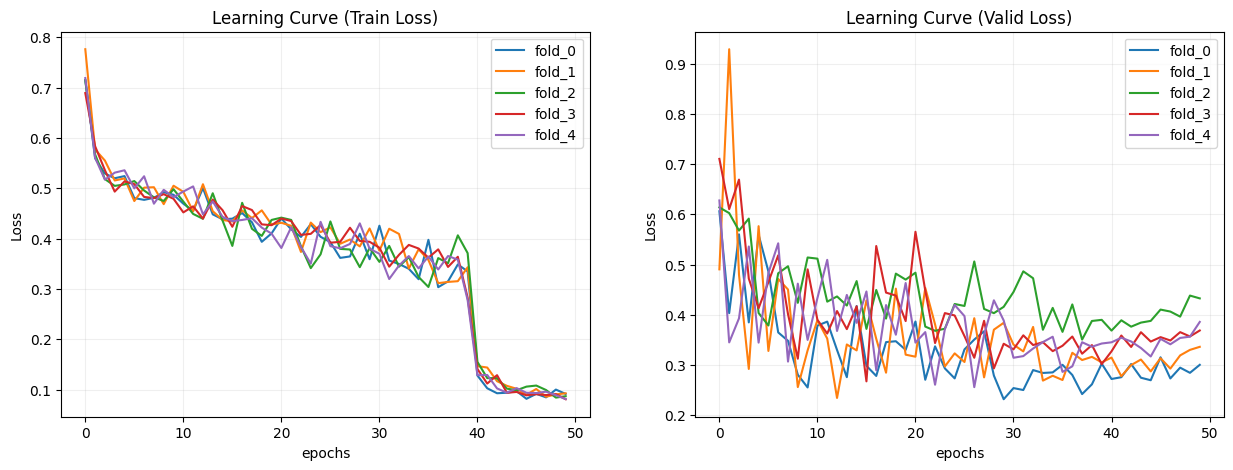

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

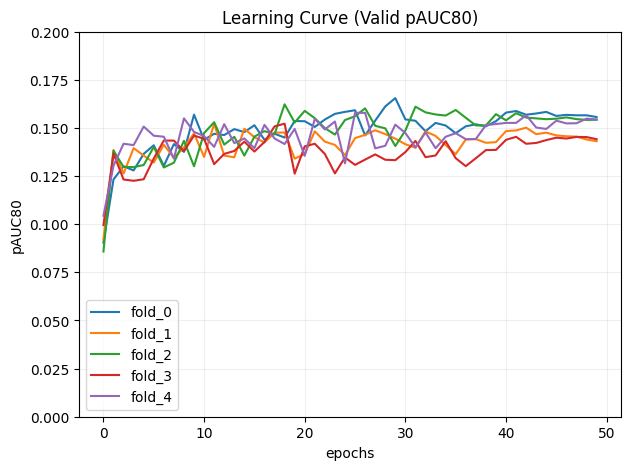

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [32]:
# data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
# table = wandb.Table(data=data, columns=["x", "y"])
# wandb.log(
#     {
#         "learning_curve_pAUC80": wandb.plot.line(
#             table, "x", "y", title="Learning Curve (Valid pAUC80)"
#         )
#     }
# )

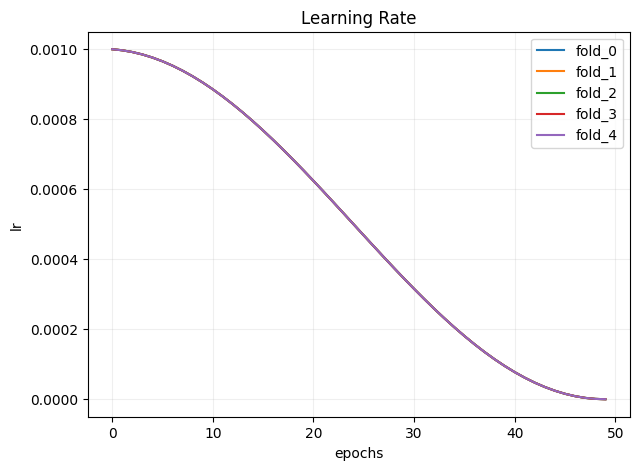

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [34]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
df_pauc

,pAUC80
fold_0,0.1557
fold_1,0.1431
fold_2,0.1543
fold_3,0.1442
fold_4,0.1544
mean,0.1503
std,0.005


In [35]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    wandb.finish()

pAUC80_fold0,▁
pAUC80_fold1,▁
pAUC80_fold2,▁
pAUC80_fold3,▁
pAUC80_fold4,▁
pAUC80_mean,▁
pAUC80_fold0,0.15568
pAUC80_fold1,0.14311
pAUC80_fold2,0.15427
pAUC80_fold3,0.14418
pAUC80_fold4,0.15444


In [36]:
# wandb.finish()